In [66]:
# Do all necessary preprocessing, calling prepro.py
import utils
from utils import *
importlib.reload(utils)
from utils import *

In [2]:
# Load data
X, X_test_original, y = load_data() 
y = y.ravel()
scores = np.array([])
xtrain = X  # For andreas cross validation
ytrain = y

# Now we construct different pipelines and test them using cross validation

The intermediate estimators have to have the fit and transform methods implemented, and the final estimator has to have the fit method implemented. If running cross validation, the models that should output a y (don't just transform data, like SVC or XGBClassifier need to have a predict method).

# SVM with 'balanced' weights

In [ ]:
# Make a SVM pipeline
kf = KFold(n_splits=3, shuffle=True)

svm_estimators = [('standardization', preprocessing.StandardScaler()), 
              ('feature_selection', SelectFromModel(RandomForestClassifier(n_estimators=300, random_state=42))),
              ('classifier', svm.SVC(class_weight='balanced'))
             ]
svm_pipe = Pipeline(svm_estimators)

score = cross_val_score(svm_pipe, X, y, cv=kf, scoring=make_scorer(balanced_accuracy_score))
print(score)

In [ ]:
# Check confusion matrix:
svm_pipe.fit(X, y)
y_pred = svm_pipe.predict(X)
plot_confusion_matrix(y, y_pred, classes=[0, 1, 2],
                      title='Confusion matrix', normalize=False)
plt.show()

# SVM ('balanced') + XGBC Ensemble

In [ ]:
# Make an XGBoost pipeline
kf = KFold(n_splits=3, shuffle=True)

xgb_estimators = [('standardization', preprocessing.StandardScaler()), 
              ('feature_selection', SelectFromModel(RandomForestClassifier(n_estimators=300, random_state=42))),
              ('classifier', xgb.XGBClassifier(random_state=42))
             ]
xgb_pipe = Pipeline(xgb_estimators)

# xgb_score = cross_val_score(xgb_pipe, X, y, cv=kf, scoring=make_scorer(balanced_accuracy_score))
# print(xgb_score)

In [ ]:
# Check confusion matrix:
xgb_pipe.fit(X, y)
y_pred = xgb_pipe.predict(X)
plot_confusion_matrix(y, y_pred, classes=[0, 1, 2],
                      title='Confusion matrix', normalize=True)
plt.show()

In [ ]:
# Create an ensemble estimator of XGB and SVM:

kf = KFold(n_splits=3, shuffle=True)

ensemble = VotingClassifier([('svm', svm.SVC(class_weight='balanced')), 
                            ('xgb', xgb.XGBClassifier(random_state=42, learning_rate=0.5, n_estimators=300, max_depth=10))], 
                           weights=None)
ensemble_estimators = [('standardization', preprocessing.StandardScaler()), 
              ('feature_selection', SelectFromModel(RandomForestClassifier(n_estimators=300, random_state=42))),
              ('classifier', ensemble)
             ]
ensemble_pipe = Pipeline(ensemble_estimators)

ensemble_score = cross_val_score(ensemble_pipe, X, y, cv=kf, scoring=make_scorer(balanced_accuracy_score), verbose=1)
print(ensemble_score)

# SVM with SMOTE

In [ ]:
# Try a SVM Estimator with SMOTE

kf = KFold(n_splits=5, shuffle=True)

# svm_smote_estimators = [
#               ('standardization', preprocessing.StandardScaler()), 
#               ('feature_selection', SelectFromModel(RandomForestClassifier(n_estimators=300, random_state=42))),
#               ('classifier', SMOTEClassifier(SMOTE('minority'), svm.SVC()))
#              ]

smote2 = SMOTE(random_state=42)
svm_pipe2 = Pipeline([('standardization', preprocessing.StandardScaler()), 
              ('classifier', svm.SVC())
             ])
svm_smote_estimators2 = [
              ('classifier', SMOTEClassifier(smote2, svm_pipe2))
             ]
# svm_smote_estimators = [
#               ('classifier', svm_pipe)
#              ]
svm_smote_pipe2 = Pipeline(svm_smote_estimators2)

score = cross_val_score(svm_smote_pipe2, X, y, cv=kf, scoring=make_scorer(balanced_accuracy_score), verbose=2)
print(score)
# Score: [0.59077241 0.6063096  0.57785729]
# Without smote, I get [0.55728494 0.54095411 0.57493051 0.57253056 0.55494866] which is same as andreas in mean
# With current smote: [0.60208197 0.60274172 0.65079332 0.64553232 0.66089551]
# SMOTE no deep copy: [0.66815703 0.58598228 0.62943226 0.6350562  0.61465314]
# SMOTE no deep copy, sklearn.base.clone(classifier): [0.61372447 0.60251485 0.65401315 0.6055938  0.63318461]
# SMOTE deep copy, sklearn.base.clone(classifier): [0.61372447 0.60251485 0.65401315 0.6055938  0.63318461]
# SMOTE instantiated inside, sklearn.base.clone (classifier): [0.64730051 0.59922761 0.64895935 0.62417725 0.61648087]

In [ ]:
# Check confusion matrix:
svm_smote_pipe2.fit(X, y)
y_pred = svm_smote_pipe2.predict(X)
plot_confusion_matrix(y, y_pred, classes=[0, 1, 2],
                      title='Confusion matrix', normalize=True)
plt.show()

In [ ]:
# Learning curve
new_nn = MLPClassifier(solver='lbfgs', alpha=1e-5,
                       hidden_layer_sizes=(15,2), random_state=1,
                      )
plot_learning_curve(new_nn, 'NN (SMOTE) learning curve', X, y, ylim=(0.7, 1.01), cv=kf)

# SVM with SMOTE using Andreas cross validation

In [ ]:
# SVM + SMOTE cross validation

kf = KFold(n_splits=5, shuffle = True)

BMAC_means = np.array([])
BMAC_stds = np.array([])
BMAC_scores = np.array([])
for train_index, test_index in kf.split(xtrain):

    x_train = xtrain[train_index]
    x_test = xtrain[test_index]

    y_train = ytrain[train_index]
    y_test = ytrain[test_index]

    sm = SMOTE(random_state=42)
    x_train, y_train = sm.fit_resample(x_train, y_train) #x_train and y_train are now arrays

    # Scale the data (should this be done for each bootstrap sample? in that case how)
    scaler = preprocessing.StandardScaler()
    x_train = scaler.fit_transform(x_train)
    scaler2 = preprocessing.StandardScaler()
    x_test = scaler2.fit_transform(x_test)

    # Model to fit
    estimator = svm.SVC()
    estimator.fit(x_train, y_train.ravel())
    pred = estimator.predict(x_test)
    BMAC = balanced_accuracy_score(y_test, pred)

    print("BMAC Score: ", BMAC)
    BMAC_scores = np.append(BMAC_scores, BMAC)

BMAC_means = np.append(BMAC_means, np.mean(BMAC_scores))
BMAC_stds = np.append(BMAC_stds, np.std(BMAC_scores))
#print(np.mean(BMAC_scores))
#print(np.std(BMAC_scores))

print(BMAC_scores)
print(BMAC_means)
print(BMAC_stds)

# WIth the sklearn pipeline: 
# BMAC Score:  0.6653723616089208
# BMAC Score:  0.5817579772284974
# BMAC Score:  0.6385067508557504
# BMAC Score:  0.6052335588793922
# BMAC Score:  0.6230010015609052
# [0.66537236 0.58175798 0.63850675 0.60523356 0.623001  ]
# [0.62277433]
# [0.02846813]

# With exactly like andreas did (no pipeline):
# BMAC Score:  0.6742004135726839
# BMAC Score:  0.6970752260765067
# BMAC Score:  0.6703766780204368
# BMAC Score:  0.6978427317254585
# BMAC Score:  0.690524245525415
# [0.67420041 0.69707523 0.67037668 0.69784273 0.69052425]
# [0.68600386]
# [0.01154728]

# With like andreas but with 2 diff standardizers for xtrain and xtest (same thing)
# BMAC Score:  0.6915209721130537
# BMAC Score:  0.6502473263231936
# BMAC Score:  0.683423031021961
# BMAC Score:  0.6919825859146247
# BMAC Score:  0.7100686782444291
# [0.69152097 0.65024733 0.68342303 0.69198259 0.71006868]
# [0.68544852]
# [0.01964153]

# XGBC with SMOTE

In [ ]:
# Try a XGBC Estimator with SMOTE

kf = KFold(n_splits=3, shuffle=True)

xgb_smote_estimators = [
              ('standardization', preprocessing.StandardScaler()), 
              ('feature_selection', SelectFromModel(RandomForestClassifier(n_estimators=300, random_state=42))),
              ('classifier', SMOTEClassifier(SMOTE(random_state=42), xgb.XGBClassifier()))
             ]
xgb_smote_pipe = Pipeline(xgb_smote_estimators)

# score = cross_val_score(xgb_smote_pipe, X, y, cv=kf, scoring=make_scorer(balanced_accuracy_score), verbose=2)
# print(score)
# Score: [0.56183764 0.53822128 0.61737798]

In [ ]:
# Check confusion matrix:
xgb_smote_pipe.fit(X, y)
y_pred = xgb_smote_pipe.predict(X)
plot_confusion_matrix(y, y_pred, classes=[0, 1, 2],
                      title='Confusion matrix', normalize=True)
plt.show()

# Neural Net

In [97]:
# Try a nn Estimator with SMOTE

kf = KFold(n_splits=5, shuffle = True)

BMAC_means = np.array([])
BMAC_stds = np.array([])
BMAC_scores = np.array([])
for train_index, test_index in kf.split(xtrain):

    x_train = xtrain[train_index]
    x_test = xtrain[test_index]

    y_train = ytrain[train_index]
    y_test = ytrain[test_index]

    sm = SMOTE(random_state=42)
    x_train, y_train = sm.fit_resample(x_train, y_train) #x_train and y_train are now arrays

    # Scale the data (should this be done for each bootstrap sample? in that case how)
    scaler = preprocessing.StandardScaler()
    x_train = scaler.fit_transform(x_train)
    scaler2 = preprocessing.StandardScaler()
    x_test = scaler2.fit_transform(x_test)

    # Model to fit
    '''
    MLPClassifier(activation='relu', alpha=1e-05, batch_size='auto',
                  beta_1=0.9, beta_2=0.999, early_stopping=False,
                  epsilon=1e-08, hidden_layer_sizes=(15,),
                  learning_rate='constant', learning_rate_init=0.001,
                  max_iter=200, momentum=0.9, n_iter_no_change=10,
                  nesterovs_momentum=True, power_t=0.5,  random_state=1,
                  shuffle=True, solver='lbfgs', tol=0.0001,
                  validation_fraction=0.1, verbose=False, warm_start=False)

    '''
    estimator = MLPClassifier(solver='lbfgs', alpha=1e-5,
                           hidden_layer_sizes=(150,150), random_state=1,
                            activation='relu', learning_rate='invscaling', beta_1=0.9, 
                              beta_2=0.999, learning_rate_init=0.001, early_stopping=True,
                              momentum=0.9, shuffle=True, epsilon=1e-08, 
                              
                          )
    estimator.fit(x_train, y_train.ravel())
    pred = estimator.predict(x_test)
    BMAC = balanced_accuracy_score(y_test, pred)

    print("BMAC Score: ", BMAC)
    BMAC_scores = np.append(BMAC_scores, BMAC)
    
#     train_sizes, train_scores, valid_scores = learning_curve(estimator, x_train, y_train, train_sizes=[50, 80, 110], cv=5)

BMAC_means = np.append(BMAC_means, np.mean(BMAC_scores))
BMAC_stds = np.append(BMAC_stds, np.std(BMAC_scores))
#print(np.mean(BMAC_scores))
#print(np.std(BMAC_scores))

print("Scores:", BMAC_scores)
print("Mean Scores:", BMAC_means)
print("Std Scores:", BMAC_stds)

# Mean Scores: [0.67625076], cv=5:
#    estimator = MLPClassifier(solver='lbfgs', alpha=1e-5,
#                            hidden_layer_sizes=(150,150), random_state=1,
#                             activation='relu', learning_rate='constant', beta_1=0.9, 
#                               beta_2=0.999, learning_rate_init=0.001
#                           )

#  Scores: [0.66639015 0.6848148  0.70958482 0.69875664 0.65585182]
# Mean Scores: [0.68307965]
# Std Scores: [0.01985546]
    
# estimator = MLPClassifier(solver='lbfgs', alpha=1e-5,
#                        hidden_layer_sizes=(150,150), random_state=1,
#                         activation='relu', learning_rate='invscaling', beta_1=0.9, 
#                           beta_2=0.999, learning_rate_init=0.001, early_stopping=True,
#                           momentum=0.9, shuffle=True, epsilon=1e-08, 

#                       )

BMAC Score:  0.6719996675437804
BMAC Score:  0.6553210516180873
BMAC Score:  0.6869477269541799
BMAC Score:  0.6562721569618122
BMAC Score:  0.6620788661635456
Scores: [0.67199967 0.65532105 0.68694773 0.65627216 0.66207887]
Mean Scores: [0.66652389]
Std Scores: [0.01181082]


Normalized confusion matrix
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]


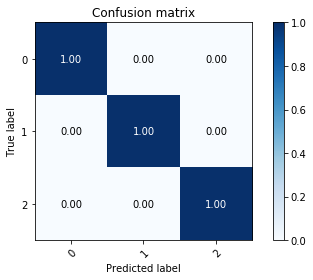

In [88]:
# Check confusion matrix:

# Choose 1 split
kf = KFold(n_splits=5, shuffle = True)
train_index, test_index = list(kf.split(X))[0]

x_train = xtrain[train_index]
x_test = xtrain[test_index]

y_train = ytrain[train_index]
y_test = ytrain[test_index]

sm = SMOTE(random_state=42)
x_train, y_train = sm.fit_resample(x_train, y_train) #x_train and y_train are now arrays

# Scale the data (should this be done for each bootstrap sample? in that case how)
scaler = preprocessing.StandardScaler()
x_train = scaler.fit_transform(x_train)
scaler2 = preprocessing.StandardScaler()
x_test = scaler2.fit_transform(x_test)

# NN model
estimator = MLPClassifier(solver='lbfgs', alpha=1e-5,
                       hidden_layer_sizes=(150,150), random_state=1,
                        activation='relu', learning_rate='invscaling', beta_1=0.9, 
                          beta_2=0.999, learning_rate_init=0.001, early_stopping=True,
                          momentum=0.9, shuffle=True, epsilon=1e-08, 

                      )

estimator.fit(x_train, y_train)
y_pred = estimator.predict(x_train)
plot_confusion_matrix(y_train, y_pred, classes=[0, 1, 2],
                      title='Confusion matrix', normalize=True)
plt.show()

In [89]:
# Make a submission

'''
produce submission file
'''
def produce_solution(y):
    with open('out.csv', 'w', newline='') as csvfile:
        writer = csv.writer(csvfile, delimiter=',', lineterminator="\n")
        writer.writerow(['id', 'y'])
        for i in range(y.shape[0]):
            writer.writerow([float(i), y[i]])

sm = SMOTE(random_state=42)
x_train, y_train = sm.fit_resample(X, y) #x_train and y_train are now arrays

# Scale the data (should this be done for each bootstrap sample? in that case how)
scaler = preprocessing.StandardScaler()
x_train = scaler.fit_transform(x_train)
scaler2 = preprocessing.StandardScaler()
x_test = scaler2.fit_transform(X_test_original)

# NN model
estimator = MLPClassifier(solver='lbfgs', alpha=1e-5,
                       hidden_layer_sizes=(150,150), random_state=1,
                        activation='relu', learning_rate='invscaling', beta_1=0.9, 
                          beta_2=0.999, learning_rate_init=0.001, early_stopping=True,
                          momentum=0.9, shuffle=True, epsilon=1e-08, 

                      )

estimator.fit(x_train, y_train)
y_pred = estimator.predict(x_test)
            
produce_solution(y_pred)

Iteration 1, loss = 1.43299747
Iteration 2, loss = 0.55793488
Iteration 3, loss = 0.41909517
Iteration 4, loss = 0.34979653
Iteration 5, loss = 0.29351383
Iteration 6, loss = 0.25624875
Iteration 7, loss = 0.21420212
Iteration 8, loss = 0.17716785
Iteration 9, loss = 0.14479983
Iteration 10, loss = 0.12097721
Iteration 11, loss = 0.09684275
Iteration 12, loss = 0.08094240
Iteration 13, loss = 0.06489712
Iteration 14, loss = 0.05351462
Iteration 15, loss = 0.04358326
Iteration 16, loss = 0.03558521
Iteration 17, loss = 0.02981081
Iteration 18, loss = 0.02449188
Iteration 19, loss = 0.02062976
Iteration 20, loss = 0.01671875
Iteration 21, loss = 0.01431368
Iteration 22, loss = 0.01220402
Iteration 23, loss = 0.01049628
Iteration 24, loss = 0.00914539
Iteration 25, loss = 0.00802674
Iteration 26, loss = 0.00715083
Iteration 27, loss = 0.00641616
Iteration 28, loss = 0.00577865
Iteration 29, loss = 0.00528588
Iteration 30, loss = 0.00480797
Iteration 31, loss = 0.00440254
Iteration 32, los

Iteration 1, loss = 0.73748235
Iteration 2, loss = 0.46546269
Iteration 3, loss = 0.39756256
Iteration 4, loss = 0.32477196
Iteration 5, loss = 0.26309892
Iteration 6, loss = 0.23706209
Iteration 7, loss = 0.20192007
Iteration 8, loss = 0.16149018
Iteration 9, loss = 0.12736498
Iteration 10, loss = 0.10075602
Iteration 11, loss = 0.07723186
Iteration 12, loss = 0.06059568
Iteration 13, loss = 0.04710190
Iteration 14, loss = 0.03436469
Iteration 15, loss = 0.02427314
Iteration 16, loss = 0.01957600
Iteration 17, loss = 0.01660619
Iteration 18, loss = 0.01343021
Iteration 19, loss = 0.01140897
Iteration 20, loss = 0.00800373
Iteration 21, loss = 0.00636081
Iteration 22, loss = 0.00553686
Iteration 23, loss = 0.00459706
Iteration 24, loss = 0.00401827
Iteration 25, loss = 0.00354152
Iteration 26, loss = 0.00312296
Iteration 27, loss = 0.00278812
Iteration 28, loss = 0.00253599
Iteration 29, loss = 0.00246148
Iteration 30, loss = 0.00233879
Iteration 31, loss = 0.00188755
Iteration 32, los

Iteration 7, loss = 0.18099181
Iteration 8, loss = 0.13897199
Iteration 9, loss = 0.11135557
Iteration 10, loss = 0.08224299
Iteration 11, loss = 0.06628631
Iteration 12, loss = 0.05707074
Iteration 13, loss = 0.05060329
Iteration 14, loss = 0.03841034
Iteration 15, loss = 0.04861365
Iteration 16, loss = 0.02363028
Iteration 17, loss = 0.01282690
Iteration 18, loss = 0.00877688
Iteration 19, loss = 0.00915660
Iteration 20, loss = 0.00610163
Iteration 21, loss = 0.00413768
Iteration 22, loss = 0.00364351
Iteration 23, loss = 0.00337123
Iteration 24, loss = 0.00230962
Iteration 25, loss = 0.00201061
Iteration 26, loss = 0.00180531
Iteration 27, loss = 0.00162947
Iteration 28, loss = 0.00150878
Iteration 29, loss = 0.00135161
Iteration 30, loss = 0.00121364
Iteration 31, loss = 0.00112312
Iteration 32, loss = 0.00105729
Iteration 33, loss = 0.00099032
Iteration 34, loss = 0.00088600
Iteration 35, loss = 0.00080973
Training loss did not improve more than tol=0.001000 for 10 consecutive epo

Iteration 7, loss = 0.20875416
Iteration 8, loss = 0.19565092
Iteration 9, loss = 0.14922929
Iteration 10, loss = 0.11824725
Iteration 11, loss = 0.09326842
Iteration 12, loss = 0.08009609
Iteration 13, loss = 0.07001236
Iteration 14, loss = 0.05502327
Iteration 15, loss = 0.03949102
Iteration 16, loss = 0.03080149
Iteration 17, loss = 0.02643118
Iteration 18, loss = 0.01988451
Iteration 19, loss = 0.01660656
Iteration 20, loss = 0.01614649
Iteration 21, loss = 0.01395937
Iteration 22, loss = 0.01119722
Iteration 23, loss = 0.00948281
Iteration 24, loss = 0.00752528
Iteration 25, loss = 0.00648496
Iteration 26, loss = 0.00565609
Iteration 27, loss = 0.00457090
Iteration 28, loss = 0.00409490
Iteration 29, loss = 0.00369466
Iteration 30, loss = 0.00330842
Iteration 31, loss = 0.00303272
Iteration 32, loss = 0.00275814
Iteration 33, loss = 0.00259276
Iteration 34, loss = 0.00242696
Iteration 35, loss = 0.00228553
Iteration 36, loss = 0.00209154
Iteration 37, loss = 0.00191265
Iteration 3

<module 'matplotlib.pyplot' from '/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

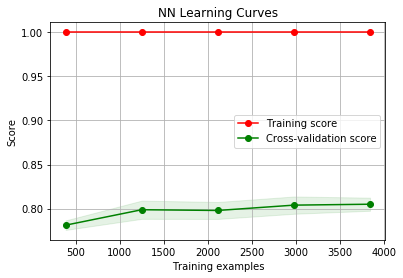

In [61]:
# Standardize the full data kek
kf = KFold(n_splits=5, shuffle = True)
scaler = preprocessing.StandardScaler()
X_standardized = scaler.fit_transform(X)

'''
MLPClassifier(activation='relu', alpha=1e-05, batch_size='auto',
              beta_1=0.9, beta_2=0.999, early_stopping=False,
              epsilon=1e-08, hidden_layer_sizes=(15,),
              learning_rate='constant', learning_rate_init=0.001,
              max_iter=200, momentum=0.9, n_iter_no_change=10,
              nesterovs_momentum=True, power_t=0.5,  random_state=1,
              shuffle=True, solver='lbfgs', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=False)

'''
estimator = MLPClassifier(solver='adam', alpha=1e-5,
                       hidden_layer_sizes=(150,150), random_state=1,
                        activation='relu', learning_rate='adaptive', beta_1=0.9, 
                          beta_2=0.999, learning_rate_init=0.001, verbose=True,
                          power_t=0.5, tol=0.001
                      )
# train_sizes, train_scores, valid_scores = learning_curve(estimator, X_standardized, y, cv=kf)
plot_learning_curve(estimator, "NN Learning Curves", X_standardized, y, ylim=None, cv=kf,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5))

# Observations: 'sgd' too slow and not better results, 'adaptive' gradient seems best

Iteration 1, loss = 0.63758719
Iteration 2, loss = 0.44476393
Iteration 3, loss = 0.36164996
Iteration 4, loss = 0.30036180
Iteration 5, loss = 0.25208929
Iteration 6, loss = 0.22703049
Iteration 7, loss = 0.19127241
Iteration 8, loss = 0.14640694
Iteration 9, loss = 0.15086179
Iteration 10, loss = 0.09755705
Iteration 11, loss = 0.07457444
Iteration 12, loss = 0.06040634
Iteration 13, loss = 0.04702093
Iteration 14, loss = 0.04167514
Iteration 15, loss = 0.02581442
Iteration 16, loss = 0.02248644
Iteration 17, loss = 0.01489569
Iteration 18, loss = 0.01100080
Iteration 19, loss = 0.00791699
Iteration 20, loss = 0.00552660
Iteration 21, loss = 0.00440576
Iteration 22, loss = 0.00355139
Iteration 23, loss = 0.00296610
Iteration 24, loss = 0.00255770
Iteration 25, loss = 0.00225298
Iteration 26, loss = 0.00208030
Iteration 27, loss = 0.00195597
Iteration 28, loss = 0.00166280
Iteration 29, loss = 0.00154138
Iteration 30, loss = 0.00127129
Iteration 31, loss = 0.00116857
Iteration 32, los

Iteration 68, loss = 0.07869730
Iteration 69, loss = 0.07682607
Iteration 70, loss = 0.07616688
Iteration 71, loss = 0.07438074
Iteration 72, loss = 0.07396734
Iteration 73, loss = 0.07319760
Iteration 74, loss = 0.07324793
Iteration 75, loss = 0.07338587
Iteration 76, loss = 0.07659520
Iteration 77, loss = 0.08244518
Iteration 78, loss = 0.08291677
Iteration 79, loss = 0.08575447
Iteration 80, loss = 0.10149922
Iteration 81, loss = 0.13745271
Iteration 82, loss = 0.14355014
Training loss did not improve more than tol=0.001000 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 1.49454165
Iteration 2, loss = 1.25234591
Iteration 3, loss = 1.11086330
Iteration 4, loss = 0.99631687
Iteration 5, loss = 0.89898330
Iteration 6, loss = 0.82925856
Iteration 7, loss = 0.75385596
Iteration 8, loss = 0.66993039
Iteration 9, loss = 0.64087516
Iteration 10, loss = 0.57845741
Iteration 11, loss = 0.52926406
Iteration 12, loss = 0.48724790
Iteration 13, loss = 0.45671357
Iteration 14, loss = 0.

Iteration 50, loss = 0.14956599
Iteration 51, loss = 0.14456600
Iteration 52, loss = 0.14085237
Iteration 53, loss = 0.14895419
Iteration 54, loss = 0.14339038
Iteration 55, loss = 0.14002542
Iteration 56, loss = 0.14349859
Iteration 57, loss = 0.14785597
Iteration 58, loss = 0.14148762
Iteration 59, loss = 0.14519931
Iteration 60, loss = 0.13595748
Iteration 61, loss = 0.13254274
Iteration 62, loss = 0.13092401
Iteration 63, loss = 0.13563772
Iteration 64, loss = 0.13457564
Iteration 65, loss = 0.14011640
Iteration 66, loss = 0.16538326
Iteration 67, loss = 0.15498706
Iteration 68, loss = 0.16919110
Iteration 69, loss = 0.15320453
Iteration 70, loss = 0.14792996
Iteration 71, loss = 0.13795643
Iteration 72, loss = 0.13413427
Iteration 73, loss = 0.13577198
Training loss did not improve more than tol=0.001000 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 2.32203461
Iteration 2, loss = 1.93715513
Iteration 3, loss = 1.65779755
Iteration 4, loss = 1.42724902
Iteration 5, loss 

Iteration 39, loss = 0.20372324
Iteration 40, loss = 0.19663369
Iteration 41, loss = 0.22099637
Iteration 42, loss = 0.22840666
Iteration 43, loss = 0.20050686
Iteration 44, loss = 0.18987086
Iteration 45, loss = 0.19592111
Iteration 46, loss = 0.20381006
Iteration 47, loss = 0.21993035
Iteration 48, loss = 0.19725832
Iteration 49, loss = 0.18986535
Iteration 50, loss = 0.18650233
Iteration 51, loss = 0.18168788
Iteration 52, loss = 0.18069724
Iteration 53, loss = 0.19113955
Iteration 54, loss = 0.17779925
Iteration 55, loss = 0.17967459
Iteration 56, loss = 0.21692964
Iteration 57, loss = 0.20916837
Iteration 58, loss = 0.18801474
Iteration 59, loss = 0.21225937
Iteration 60, loss = 0.19717266
Iteration 61, loss = 0.19044313
Iteration 62, loss = 0.18054239
Iteration 63, loss = 0.18018416
Iteration 64, loss = 0.17248537
Iteration 65, loss = 0.17267292
Iteration 66, loss = 0.17430372
Iteration 67, loss = 0.16656361
Iteration 68, loss = 0.17197182
Iteration 69, loss = 0.16503055
Iteratio

Iteration 31, loss = 0.25316168
Iteration 32, loss = 0.24756769
Iteration 33, loss = 0.23625158
Iteration 34, loss = 0.23607942
Iteration 35, loss = 0.24122846
Iteration 36, loss = 0.24710380
Iteration 37, loss = 0.24769301
Iteration 38, loss = 0.25128065
Iteration 39, loss = 0.25077857
Iteration 40, loss = 0.24480995
Iteration 41, loss = 0.27387053
Iteration 42, loss = 0.27203407
Iteration 43, loss = 0.23815750
Iteration 44, loss = 0.22613593
Iteration 45, loss = 0.22802596
Iteration 46, loss = 0.23295859
Iteration 47, loss = 0.22484067
Iteration 48, loss = 0.21777363
Iteration 49, loss = 0.21677854
Iteration 50, loss = 0.22283023
Iteration 51, loss = 0.21560135
Iteration 52, loss = 0.21294721
Iteration 53, loss = 0.23122756
Iteration 54, loss = 0.21813909
Iteration 55, loss = 0.22986271
Iteration 56, loss = 0.25436718
Iteration 57, loss = 0.24018758
Iteration 58, loss = 0.22670309
Iteration 59, loss = 0.23662050
Iteration 60, loss = 0.22277472
Iteration 61, loss = 0.21314753
Iteratio

Iteration 16, loss = 0.47684307
Iteration 17, loss = 0.42207195
Iteration 18, loss = 0.40152832
Iteration 19, loss = 0.40271105
Iteration 20, loss = 0.42596530
Iteration 21, loss = 0.37136988
Iteration 22, loss = 0.34814804
Iteration 23, loss = 0.33341918
Iteration 24, loss = 0.34279986
Iteration 25, loss = 0.36822826
Iteration 26, loss = 0.34297362
Iteration 27, loss = 0.32015274
Iteration 28, loss = 0.30908998
Iteration 29, loss = 0.29435379
Iteration 30, loss = 0.27717789
Iteration 31, loss = 0.28331517
Iteration 32, loss = 0.27997402
Iteration 33, loss = 0.26718873
Iteration 34, loss = 0.26871041
Iteration 35, loss = 0.27509367
Iteration 36, loss = 0.28781160
Iteration 37, loss = 0.27640965
Iteration 38, loss = 0.28966893
Iteration 39, loss = 0.27111157
Iteration 40, loss = 0.25941038
Iteration 41, loss = 0.28797428
Iteration 42, loss = 0.28506016
Iteration 43, loss = 0.26380101
Iteration 44, loss = 0.25180227
Iteration 45, loss = 0.26511077
Iteration 46, loss = 0.28071318
Iteratio

Iteration 2, loss = 3.43082727
Iteration 3, loss = 2.62217306
Iteration 4, loss = 2.03079360
Iteration 5, loss = 1.60522250
Iteration 6, loss = 1.31348917
Iteration 7, loss = 1.09787754
Iteration 8, loss = 0.93130537
Iteration 9, loss = 0.83553543
Iteration 10, loss = 0.73047409
Iteration 11, loss = 0.65130997
Iteration 12, loss = 0.59537610
Iteration 13, loss = 0.54382376
Iteration 14, loss = 0.52642431
Iteration 15, loss = 0.48817596
Iteration 16, loss = 0.48104245
Iteration 17, loss = 0.43363343
Iteration 18, loss = 0.42229961
Iteration 19, loss = 0.41604031
Iteration 20, loss = 0.41441602
Iteration 21, loss = 0.38021694
Iteration 22, loss = 0.36822826
Iteration 23, loss = 0.35279846
Iteration 24, loss = 0.36064979
Iteration 25, loss = 0.38188150
Iteration 26, loss = 0.36153995
Iteration 27, loss = 0.33823727
Iteration 28, loss = 0.33842853
Iteration 29, loss = 0.33417804
Iteration 30, loss = 0.31104140
Iteration 31, loss = 0.30978946
Iteration 32, loss = 0.30632734
Iteration 33, lo

Iteration 37, loss = 0.33099159
Iteration 38, loss = 0.34338846
Iteration 39, loss = 0.33110770
Iteration 40, loss = 0.32260298
Iteration 41, loss = 0.33674255
Iteration 42, loss = 0.33262604
Iteration 43, loss = 0.32136132
Iteration 44, loss = 0.31516279
Iteration 45, loss = 0.32600495
Iteration 46, loss = 0.34190913
Iteration 47, loss = 0.33307804
Iteration 48, loss = 0.32604643
Iteration 49, loss = 0.32816272
Iteration 50, loss = 0.32476127
Iteration 51, loss = 0.32033022
Iteration 52, loss = 0.32446165
Iteration 53, loss = 0.34261882
Iteration 54, loss = 0.32218058
Iteration 55, loss = 0.31145255
Iteration 56, loss = 0.31363033
Iteration 57, loss = 0.30547759
Iteration 58, loss = 0.30586338
Iteration 59, loss = 0.31844627
Iteration 60, loss = 0.30838409
Iteration 61, loss = 0.30254433
Iteration 62, loss = 0.29957644
Iteration 63, loss = 0.30755892
Iteration 64, loss = 0.30203590
Iteration 65, loss = 0.31278370
Iteration 66, loss = 0.29703536
Iteration 67, loss = 0.29868431
Iteratio

Iteration 43, loss = 0.08786295
Iteration 44, loss = 0.08586485
Iteration 45, loss = 0.08362964
Iteration 46, loss = 0.08194278
Iteration 47, loss = 0.07959831
Iteration 48, loss = 0.07735690
Iteration 49, loss = 0.07540498
Iteration 50, loss = 0.07365676
Iteration 51, loss = 0.07202830
Iteration 52, loss = 0.07038601
Iteration 53, loss = 0.06941959
Iteration 54, loss = 0.29373708
Iteration 55, loss = 0.36824262
Iteration 56, loss = 0.31434309
Iteration 57, loss = 0.23308600
Iteration 58, loss = 0.16394399
Iteration 59, loss = 0.15043323
Iteration 60, loss = 0.12043361
Iteration 61, loss = 0.10359333
Iteration 62, loss = 0.09446540
Iteration 63, loss = 0.08742495
Training loss did not improve more than tol=0.001000 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 1.08257686
Iteration 2, loss = 0.86466386
Iteration 3, loss = 0.77605405
Iteration 4, loss = 0.70512305
Iteration 5, loss = 0.64025993
Iteration 6, loss = 0.58747601
Iteration 7, loss = 0.53141034
Iteration 8, loss = 0

Iteration 78, loss = 0.08464633
Iteration 79, loss = 0.08428607
Iteration 80, loss = 0.08434652
Iteration 81, loss = 0.08292519
Iteration 82, loss = 0.08264640
Iteration 83, loss = 0.08500661
Iteration 84, loss = 0.08248890
Iteration 85, loss = 0.08780601
Iteration 86, loss = 0.08747846
Iteration 87, loss = 0.09269077
Iteration 88, loss = 0.10589666
Iteration 89, loss = 0.13248583
Iteration 90, loss = 0.15590560
Iteration 91, loss = 0.13010754
Iteration 92, loss = 0.11851510
Training loss did not improve more than tol=0.001000 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 1.71746720
Iteration 2, loss = 1.43269814
Iteration 3, loss = 1.27030728
Iteration 4, loss = 1.13539701
Iteration 5, loss = 1.01149509
Iteration 6, loss = 0.90789325
Iteration 7, loss = 0.80768669
Iteration 8, loss = 0.72558978
Iteration 9, loss = 0.65885749
Iteration 10, loss = 0.60752633
Iteration 11, loss = 0.56837869
Iteration 12, loss = 0.52584930
Iteration 13, loss = 0.47873108
Iteration 14, loss = 0.

Iteration 76, loss = 0.12507753
Iteration 77, loss = 0.12220561
Iteration 78, loss = 0.12257209
Iteration 79, loss = 0.12418464
Iteration 80, loss = 0.12534590
Iteration 81, loss = 0.12307739
Iteration 82, loss = 0.12538716
Iteration 83, loss = 0.12490241
Iteration 84, loss = 0.12387375
Iteration 85, loss = 0.12251303
Iteration 86, loss = 0.12351772
Iteration 87, loss = 0.12065020
Iteration 88, loss = 0.12166516
Iteration 89, loss = 0.12364460
Iteration 90, loss = 0.12291222
Iteration 91, loss = 0.12912828
Iteration 92, loss = 0.13128925
Iteration 93, loss = 0.13948118
Iteration 94, loss = 0.13775563
Iteration 95, loss = 0.13808689
Iteration 96, loss = 0.13183157
Iteration 97, loss = 0.12755092
Iteration 98, loss = 0.12278706
Training loss did not improve more than tol=0.001000 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 2.33578054
Iteration 2, loss = 1.93802313
Iteration 3, loss = 1.66271965
Iteration 4, loss = 1.43804957
Iteration 5, loss = 1.23997415
Iteration 6, loss =

Iteration 21, loss = 0.37941914
Iteration 22, loss = 0.32366639
Iteration 23, loss = 0.31328549
Iteration 24, loss = 0.30706596
Iteration 25, loss = 0.27665864
Iteration 26, loss = 0.26973308
Iteration 27, loss = 0.26570904
Iteration 28, loss = 0.27191723
Iteration 29, loss = 0.29668114
Iteration 30, loss = 0.25733533
Iteration 31, loss = 0.23454925
Iteration 32, loss = 0.22461473
Iteration 33, loss = 0.22298743
Iteration 34, loss = 0.21296480
Iteration 35, loss = 0.21718225
Iteration 36, loss = 0.21690727
Iteration 37, loss = 0.21708555
Iteration 38, loss = 0.20435323
Iteration 39, loss = 0.20191784
Iteration 40, loss = 0.20262138
Iteration 41, loss = 0.21898981
Iteration 42, loss = 0.21276729
Iteration 43, loss = 0.19630926
Iteration 44, loss = 0.20178707
Iteration 45, loss = 0.20218991
Iteration 46, loss = 0.21339838
Iteration 47, loss = 0.24077717
Iteration 48, loss = 0.21885854
Iteration 49, loss = 0.22323662
Iteration 50, loss = 0.20251115
Iteration 51, loss = 0.19707918
Iteratio

Iteration 13, loss = 0.55011322
Iteration 14, loss = 0.49488039
Iteration 15, loss = 0.45493853
Iteration 16, loss = 0.41650478
Iteration 17, loss = 0.41511654
Iteration 18, loss = 0.38572783
Iteration 19, loss = 0.38346536
Iteration 20, loss = 0.38141424
Iteration 21, loss = 0.37142653
Iteration 22, loss = 0.38506876
Iteration 23, loss = 0.34672703
Iteration 24, loss = 0.31908357
Iteration 25, loss = 0.30411946
Iteration 26, loss = 0.28569666
Iteration 27, loss = 0.28159145
Iteration 28, loss = 0.27236611
Iteration 29, loss = 0.30542782
Iteration 30, loss = 0.27173150
Iteration 31, loss = 0.25940773
Iteration 32, loss = 0.25601350
Iteration 33, loss = 0.25308050
Iteration 34, loss = 0.24402840
Iteration 35, loss = 0.25136762
Iteration 36, loss = 0.25575988
Iteration 37, loss = 0.26521648
Iteration 38, loss = 0.24528385
Iteration 39, loss = 0.24243086
Iteration 40, loss = 0.23942978
Iteration 41, loss = 0.25999068
Iteration 42, loss = 0.25189683
Iteration 43, loss = 0.23008529
Iteratio

Iteration 2, loss = 3.32349823
Iteration 3, loss = 2.56214161
Iteration 4, loss = 2.00356464
Iteration 5, loss = 1.59630659
Iteration 6, loss = 1.30592968
Iteration 7, loss = 1.08288748
Iteration 8, loss = 0.92260681
Iteration 9, loss = 0.81314858
Iteration 10, loss = 0.73342814
Iteration 11, loss = 0.65868881
Iteration 12, loss = 0.58644967
Iteration 13, loss = 0.54690442
Iteration 14, loss = 0.50224263
Iteration 15, loss = 0.46591474
Iteration 16, loss = 0.43239187
Iteration 17, loss = 0.43616099
Iteration 18, loss = 0.41362552
Iteration 19, loss = 0.39721284
Iteration 20, loss = 0.41467789
Iteration 21, loss = 0.39734845
Iteration 22, loss = 0.38476973
Iteration 23, loss = 0.37296161
Iteration 24, loss = 0.33867781
Iteration 25, loss = 0.33057559
Iteration 26, loss = 0.31870851
Iteration 27, loss = 0.31764837
Iteration 28, loss = 0.30796541
Iteration 29, loss = 0.35948984
Iteration 30, loss = 0.32560135
Iteration 31, loss = 0.30445877
Iteration 32, loss = 0.29659492
Iteration 33, lo

Iteration 31, loss = 0.32934685
Iteration 32, loss = 0.32644484
Iteration 33, loss = 0.32752123
Iteration 34, loss = 0.32099076
Iteration 35, loss = 0.32437790
Iteration 36, loss = 0.31686396
Iteration 37, loss = 0.32724855
Iteration 38, loss = 0.31349268
Iteration 39, loss = 0.30687468
Iteration 40, loss = 0.32563487
Iteration 41, loss = 0.34059182
Iteration 42, loss = 0.32761633
Iteration 43, loss = 0.30765252
Iteration 44, loss = 0.31786900
Iteration 45, loss = 0.31027898
Iteration 46, loss = 0.30229539
Iteration 47, loss = 0.30346407
Iteration 48, loss = 0.30016556
Iteration 49, loss = 0.30967616
Iteration 50, loss = 0.30328745
Iteration 51, loss = 0.31289307
Iteration 52, loss = 0.30007827
Iteration 53, loss = 0.30488816
Iteration 54, loss = 0.29960950
Iteration 55, loss = 0.30073838
Iteration 56, loss = 0.29250331
Iteration 57, loss = 0.29514293
Iteration 58, loss = 0.31059528
Iteration 59, loss = 0.31539663
Iteration 60, loss = 0.29843520
Iteration 61, loss = 0.29243022
Iteratio

Iteration 71, loss = 0.33550242
Iteration 72, loss = 0.31789582
Training loss did not improve more than tol=0.001000 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 0.64020699
Iteration 2, loss = 0.45375192
Iteration 3, loss = 0.36535214
Iteration 4, loss = 0.29989023
Iteration 5, loss = 0.26294606
Iteration 6, loss = 0.21521322
Iteration 7, loss = 0.17290160
Iteration 8, loss = 0.14688041
Iteration 9, loss = 0.11438281
Iteration 10, loss = 0.08955941
Iteration 11, loss = 0.06569462
Iteration 12, loss = 0.04950183
Iteration 13, loss = 0.04094619
Iteration 14, loss = 0.03343195
Iteration 15, loss = 0.02026761
Iteration 16, loss = 0.01639229
Iteration 17, loss = 0.01197617
Iteration 18, loss = 0.00870137
Iteration 19, loss = 0.01019992
Iteration 20, loss = 0.00737855
Iteration 21, loss = 0.00557300
Iteration 22, loss = 0.00380508
Iteration 23, loss = 0.00276115
Iteration 24, loss = 0.00231511
Iteration 25, loss = 0.00207245
Iteration 26, loss = 0.00188272
Iteration 27, loss = 0.

Iteration 10, loss = 0.58268921
Iteration 11, loss = 0.52886868
Iteration 12, loss = 0.48299182
Iteration 13, loss = 0.45757868
Iteration 14, loss = 0.42356653
Iteration 15, loss = 0.38987792
Iteration 16, loss = 0.37678121
Iteration 17, loss = 0.35168042
Iteration 18, loss = 0.33348860
Iteration 19, loss = 0.31227202
Iteration 20, loss = 0.31012159
Iteration 21, loss = 0.28682191
Iteration 22, loss = 0.27213641
Iteration 23, loss = 0.25162528
Iteration 24, loss = 0.23830836
Iteration 25, loss = 0.23579271
Iteration 26, loss = 0.22674255
Iteration 27, loss = 0.22177723
Iteration 28, loss = 0.28593584
Iteration 29, loss = 0.29308132
Iteration 30, loss = 0.26153091
Iteration 31, loss = 0.23452466
Iteration 32, loss = 0.20933187
Iteration 33, loss = 0.19052211
Iteration 34, loss = 0.18007806
Iteration 35, loss = 0.17109529
Iteration 36, loss = 0.16462371
Iteration 37, loss = 0.15928141
Iteration 38, loss = 0.15315121
Iteration 39, loss = 0.14890166
Iteration 40, loss = 0.14455811
Iteratio

Iteration 54, loss = 0.14725835
Iteration 55, loss = 0.14243202
Iteration 56, loss = 0.14130392
Iteration 57, loss = 0.13986908
Iteration 58, loss = 0.13756192
Iteration 59, loss = 0.13870526
Iteration 60, loss = 0.13417744
Iteration 61, loss = 0.13224535
Iteration 62, loss = 0.13245786
Iteration 63, loss = 0.13217627
Iteration 64, loss = 0.13057330
Iteration 65, loss = 0.13142650
Iteration 66, loss = 0.12959381
Iteration 67, loss = 0.13049028
Iteration 68, loss = 0.12738293
Iteration 69, loss = 0.12961827
Iteration 70, loss = 0.12855176
Iteration 71, loss = 0.12980560
Iteration 72, loss = 0.12737483
Iteration 73, loss = 0.14761501
Iteration 74, loss = 0.14438328
Iteration 75, loss = 0.14305801
Iteration 76, loss = 0.13737123
Iteration 77, loss = 0.14021359
Iteration 78, loss = 0.13933223
Iteration 79, loss = 0.14481121
Training loss did not improve more than tol=0.001000 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 2.32655036
Iteration 2, loss = 1.95013740
Iteration 3, los

Iteration 62, loss = 0.17058066
Iteration 63, loss = 0.17446581
Iteration 64, loss = 0.17325033
Iteration 65, loss = 0.16930986
Iteration 66, loss = 0.16776257
Iteration 67, loss = 0.17246313
Iteration 68, loss = 0.16637682
Iteration 69, loss = 0.16526183
Iteration 70, loss = 0.16521805
Iteration 71, loss = 0.16523098
Iteration 72, loss = 0.16294743
Iteration 73, loss = 0.18404240
Iteration 74, loss = 0.18149372
Iteration 75, loss = 0.17616271
Iteration 76, loss = 0.17130581
Iteration 77, loss = 0.17385722
Iteration 78, loss = 0.17963683
Iteration 79, loss = 0.18887443
Iteration 80, loss = 0.18130246
Iteration 81, loss = 0.19045232
Iteration 82, loss = 0.19668380
Iteration 83, loss = 0.19079008
Training loss did not improve more than tol=0.001000 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 2.93040289
Iteration 2, loss = 2.40700331
Iteration 3, loss = 1.99712153
Iteration 4, loss = 1.66660684
Iteration 5, loss = 1.41914012
Iteration 6, loss = 1.21266822
Iteration 7, loss = 

Iteration 70, loss = 0.20146883
Iteration 71, loss = 0.20052821
Iteration 72, loss = 0.19844179
Iteration 73, loss = 0.21592756
Iteration 74, loss = 0.21390925
Iteration 75, loss = 0.21269752
Iteration 76, loss = 0.21608147
Iteration 77, loss = 0.20774336
Iteration 78, loss = 0.21537821
Iteration 79, loss = 0.23089747
Iteration 80, loss = 0.22351885
Iteration 81, loss = 0.22161843
Iteration 82, loss = 0.22548430
Iteration 83, loss = 0.20553905
Training loss did not improve more than tol=0.001000 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 3.52182602
Iteration 2, loss = 2.82910963
Iteration 3, loss = 2.27512676
Iteration 4, loss = 1.84654629
Iteration 5, loss = 1.53276457
Iteration 6, loss = 1.28721229
Iteration 7, loss = 1.09257394
Iteration 8, loss = 0.95815629
Iteration 9, loss = 0.85039818
Iteration 10, loss = 0.74832429
Iteration 11, loss = 0.67195916
Iteration 12, loss = 0.60271089
Iteration 13, loss = 0.56224567
Iteration 14, loss = 0.53150594
Iteration 15, loss = 0.

Iteration 78, loss = 0.24457301
Iteration 79, loss = 0.24803476
Training loss did not improve more than tol=0.001000 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 4.10228016
Iteration 2, loss = 3.21608928
Iteration 3, loss = 2.51338257
Iteration 4, loss = 1.98573863
Iteration 5, loss = 1.61049158
Iteration 6, loss = 1.32860546
Iteration 7, loss = 1.11360804
Iteration 8, loss = 0.96742201
Iteration 9, loss = 0.86330464
Iteration 10, loss = 0.74517211
Iteration 11, loss = 0.67524280
Iteration 12, loss = 0.60206031
Iteration 13, loss = 0.56514217
Iteration 14, loss = 0.54020719
Iteration 15, loss = 0.50537373
Iteration 16, loss = 0.49335072
Iteration 17, loss = 0.44747514
Iteration 18, loss = 0.42350273
Iteration 19, loss = 0.41715851
Iteration 20, loss = 0.42015901
Iteration 21, loss = 0.38133491
Iteration 22, loss = 0.35396736
Iteration 23, loss = 0.33830664
Iteration 24, loss = 0.33048185
Iteration 25, loss = 0.33213297
Iteration 26, loss = 0.32205723
Iteration 27, loss = 0.

Iteration 8, loss = 0.97981794
Iteration 9, loss = 0.85608082
Iteration 10, loss = 0.75034497
Iteration 11, loss = 0.67630598
Iteration 12, loss = 0.60689935
Iteration 13, loss = 0.56783611
Iteration 14, loss = 0.55005968
Iteration 15, loss = 0.51287612
Iteration 16, loss = 0.50883883
Iteration 17, loss = 0.46057242
Iteration 18, loss = 0.44346774
Iteration 19, loss = 0.41804885
Iteration 20, loss = 0.42646818
Iteration 21, loss = 0.40133999
Iteration 22, loss = 0.37528637
Iteration 23, loss = 0.36282409
Iteration 24, loss = 0.35224568
Iteration 25, loss = 0.35914094
Iteration 26, loss = 0.34421360
Iteration 27, loss = 0.35984136
Iteration 28, loss = 0.35095045
Iteration 29, loss = 0.34597223
Iteration 30, loss = 0.36005355
Iteration 31, loss = 0.34046870
Iteration 32, loss = 0.33705397
Iteration 33, loss = 0.33298952
Iteration 34, loss = 0.32713096
Iteration 35, loss = 0.30845450
Iteration 36, loss = 0.31695130
Iteration 37, loss = 0.30893018
Iteration 38, loss = 0.30848519
Iteration 

Iteration 20, loss = 0.43453061
Iteration 21, loss = 0.40917587
Iteration 22, loss = 0.39270709
Iteration 23, loss = 0.38269812
Iteration 24, loss = 0.37081834
Iteration 25, loss = 0.39009062
Iteration 26, loss = 0.37275897
Iteration 27, loss = 0.37788572
Iteration 28, loss = 0.36345395
Iteration 29, loss = 0.36463422
Iteration 30, loss = 0.37605356
Iteration 31, loss = 0.36279490
Iteration 32, loss = 0.36315412
Iteration 33, loss = 0.36486418
Iteration 34, loss = 0.36140039
Iteration 35, loss = 0.34188079
Iteration 36, loss = 0.35001837
Iteration 37, loss = 0.35361125
Iteration 38, loss = 0.34551797
Iteration 39, loss = 0.34010585
Iteration 40, loss = 0.34923309
Iteration 41, loss = 0.33045424
Iteration 42, loss = 0.33510930
Iteration 43, loss = 0.33559654
Iteration 44, loss = 0.33370370
Iteration 45, loss = 0.33388823
Iteration 46, loss = 0.32436631
Iteration 47, loss = 0.31944046
Iteration 48, loss = 0.32558510
Iteration 49, loss = 0.33584999
Iteration 50, loss = 0.32458463
Iteratio

Iteration 10, loss = 0.40723366
Iteration 11, loss = 0.38066026
Iteration 12, loss = 0.35331065
Iteration 13, loss = 0.32675471
Iteration 14, loss = 0.30919621
Iteration 15, loss = 0.30222208
Iteration 16, loss = 0.28087228
Iteration 17, loss = 0.27073883
Iteration 18, loss = 0.25643518
Iteration 19, loss = 0.24734057
Iteration 20, loss = 0.23331559
Iteration 21, loss = 0.21959155
Iteration 22, loss = 0.20830782
Iteration 23, loss = 0.19841577
Iteration 24, loss = 0.19062519
Iteration 25, loss = 0.18355738
Iteration 26, loss = 0.17558302
Iteration 27, loss = 0.16954568
Iteration 28, loss = 0.16225662
Iteration 29, loss = 0.15665918
Iteration 30, loss = 0.15144332
Iteration 31, loss = 0.14573265
Iteration 32, loss = 0.14284232
Iteration 33, loss = 0.14357964
Iteration 34, loss = 0.14703913
Iteration 35, loss = 0.25523897
Iteration 36, loss = 0.25230316
Iteration 37, loss = 0.21427180
Iteration 38, loss = 0.20589556
Iteration 39, loss = 0.16620505
Iteration 40, loss = 0.16334891
Iteratio

Iteration 38, loss = 0.15317752
Iteration 39, loss = 0.14776957
Iteration 40, loss = 0.14155560
Iteration 41, loss = 0.13668775
Iteration 42, loss = 0.13874372
Iteration 43, loss = 0.13369695
Iteration 44, loss = 0.13313023
Iteration 45, loss = 0.12904896
Iteration 46, loss = 0.13171811
Iteration 47, loss = 0.20877223
Iteration 48, loss = 0.20304637
Iteration 49, loss = 0.18185846
Iteration 50, loss = 0.18881075
Iteration 51, loss = 0.16480081
Iteration 52, loss = 0.15256743
Iteration 53, loss = 0.16131226
Iteration 54, loss = 0.13628068
Iteration 55, loss = 0.13457059
Iteration 56, loss = 0.14401894
Training loss did not improve more than tol=0.001000 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 1.93875009
Iteration 2, loss = 1.60272900
Iteration 3, loss = 1.39929565
Iteration 4, loss = 1.23937863
Iteration 5, loss = 1.08699840
Iteration 6, loss = 0.96121226
Iteration 7, loss = 0.85540880
Iteration 8, loss = 0.77231658
Iteration 9, loss = 0.71309162
Iteration 10, loss = 0.

Iteration 16, loss = 0.41975612
Iteration 17, loss = 0.39664036
Iteration 18, loss = 0.39492782
Iteration 19, loss = 0.37168808
Iteration 20, loss = 0.33879035
Iteration 21, loss = 0.31958895
Iteration 22, loss = 0.29629446
Iteration 23, loss = 0.27580134
Iteration 24, loss = 0.26218496
Iteration 25, loss = 0.26049276
Iteration 26, loss = 0.24848861
Iteration 27, loss = 0.26273885
Iteration 28, loss = 0.24858063
Iteration 29, loss = 0.24981972
Iteration 30, loss = 0.24887945
Iteration 31, loss = 0.22441219
Iteration 32, loss = 0.21677456
Iteration 33, loss = 0.21623142
Iteration 34, loss = 0.22227645
Iteration 35, loss = 0.23994909
Iteration 36, loss = 0.21383944
Iteration 37, loss = 0.20384836
Iteration 38, loss = 0.19075811
Iteration 39, loss = 0.19137509
Iteration 40, loss = 0.18286226
Iteration 41, loss = 0.17860178
Iteration 42, loss = 0.18625052
Iteration 43, loss = 0.17775456
Iteration 44, loss = 0.17498129
Iteration 45, loss = 0.17652589
Iteration 46, loss = 0.17256015
Iteratio

Iteration 17, loss = 0.40779631
Iteration 18, loss = 0.41139693
Iteration 19, loss = 0.38548095
Iteration 20, loss = 0.36212000
Iteration 21, loss = 0.34946158
Iteration 22, loss = 0.33742812
Iteration 23, loss = 0.30671016
Iteration 24, loss = 0.29626680
Iteration 25, loss = 0.30638761
Iteration 26, loss = 0.29256996
Iteration 27, loss = 0.29289962
Iteration 28, loss = 0.29384858
Iteration 29, loss = 0.26387733
Iteration 30, loss = 0.28053458
Iteration 31, loss = 0.27112901
Iteration 32, loss = 0.27460441
Iteration 33, loss = 0.25482499
Iteration 34, loss = 0.25173331
Iteration 35, loss = 0.26564173
Iteration 36, loss = 0.24139768
Iteration 37, loss = 0.23598301
Iteration 38, loss = 0.22931440
Iteration 39, loss = 0.23210755
Iteration 40, loss = 0.22411438
Iteration 41, loss = 0.21939444
Iteration 42, loss = 0.22764323
Iteration 43, loss = 0.22768738
Iteration 44, loss = 0.22332299
Iteration 45, loss = 0.22894508
Iteration 46, loss = 0.21958696
Iteration 47, loss = 0.22583928
Iteratio

Iteration 40, loss = 0.26568303
Iteration 41, loss = 0.26305188
Iteration 42, loss = 0.28567120
Iteration 43, loss = 0.28090779
Iteration 44, loss = 0.27805877
Iteration 45, loss = 0.27662289
Iteration 46, loss = 0.25899233
Iteration 47, loss = 0.26219932
Iteration 48, loss = 0.27212989
Iteration 49, loss = 0.28749902
Iteration 50, loss = 0.28034049
Iteration 51, loss = 0.26580045
Iteration 52, loss = 0.27242795
Iteration 53, loss = 0.27338322
Iteration 54, loss = 0.27811648
Iteration 55, loss = 0.27333411
Iteration 56, loss = 0.28774146
Iteration 57, loss = 0.27254479
Training loss did not improve more than tol=0.001000 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 4.30155857
Iteration 2, loss = 3.29230558
Iteration 3, loss = 2.52752670
Iteration 4, loss = 1.98696034
Iteration 5, loss = 1.57647277
Iteration 6, loss = 1.28473371
Iteration 7, loss = 1.07413442
Iteration 8, loss = 0.93042073
Iteration 9, loss = 0.82257725
Iteration 10, loss = 0.72128029
Iteration 11, loss = 0.

Iteration 37, loss = 0.31918864
Iteration 38, loss = 0.31159808
Iteration 39, loss = 0.31877734
Iteration 40, loss = 0.30863508
Iteration 41, loss = 0.30545754
Iteration 42, loss = 0.33132882
Iteration 43, loss = 0.33141360
Iteration 44, loss = 0.31692236
Iteration 45, loss = 0.32166628
Iteration 46, loss = 0.31061370
Iteration 47, loss = 0.30760172
Iteration 48, loss = 0.31002935
Iteration 49, loss = 0.30958500
Iteration 50, loss = 0.31460938
Iteration 51, loss = 0.30004012
Iteration 52, loss = 0.30600853
Iteration 53, loss = 0.29598727
Iteration 54, loss = 0.31109837
Iteration 55, loss = 0.31064688
Iteration 56, loss = 0.32363717
Iteration 57, loss = 0.31039190
Iteration 58, loss = 0.30111269
Iteration 59, loss = 0.29517772
Iteration 60, loss = 0.29923802
Iteration 61, loss = 0.30257164
Iteration 62, loss = 0.30580152
Iteration 63, loss = 0.30818341
Iteration 64, loss = 0.30914019
Training loss did not improve more than tol=0.001000 for 10 consecutive epochs. Stopping.
Iteration 1, l

Iteration 15, loss = 0.02535611
Iteration 16, loss = 0.01977342
Iteration 17, loss = 0.01919462
Iteration 18, loss = 0.01260493
Iteration 19, loss = 0.00800426
Iteration 20, loss = 0.00663997
Iteration 21, loss = 0.00498341
Iteration 22, loss = 0.00396149
Iteration 23, loss = 0.00339242
Iteration 24, loss = 0.00294522
Iteration 25, loss = 0.00248205
Iteration 26, loss = 0.00226245
Iteration 27, loss = 0.00194231
Iteration 28, loss = 0.00175393
Iteration 29, loss = 0.00151968
Iteration 30, loss = 0.00145691
Iteration 31, loss = 0.00133131
Iteration 32, loss = 0.00115302
Iteration 33, loss = 0.00106233
Training loss did not improve more than tol=0.001000 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 0.87049775
Iteration 2, loss = 0.64754877
Iteration 3, loss = 0.58597646
Iteration 4, loss = 0.52266774
Iteration 5, loss = 0.46896651
Iteration 6, loss = 0.41997967
Iteration 7, loss = 0.38541230
Iteration 8, loss = 0.34233367
Iteration 9, loss = 0.32006040
Iteration 10, loss = 0.

Iteration 13, loss = 0.45560341
Iteration 14, loss = 0.41673325
Iteration 15, loss = 0.39224196
Iteration 16, loss = 0.38306772
Iteration 17, loss = 0.36790342
Iteration 18, loss = 0.34735317
Iteration 19, loss = 0.31646020
Iteration 20, loss = 0.29524670
Iteration 21, loss = 0.27506261
Iteration 22, loss = 0.25928583
Iteration 23, loss = 0.24702060
Iteration 24, loss = 0.23657182
Iteration 25, loss = 0.22509442
Iteration 26, loss = 0.21769078
Iteration 27, loss = 0.20563381
Iteration 28, loss = 0.19784605
Iteration 29, loss = 0.22202627
Iteration 30, loss = 0.31470905
Iteration 31, loss = 0.26594069
Iteration 32, loss = 0.22254629
Iteration 33, loss = 0.19750057
Iteration 34, loss = 0.18290233
Iteration 35, loss = 0.17198010
Iteration 36, loss = 0.16671408
Iteration 37, loss = 0.15898500
Iteration 38, loss = 0.15265457
Iteration 39, loss = 0.14787213
Iteration 40, loss = 0.14241959
Iteration 41, loss = 0.14180352
Iteration 42, loss = 0.13763901
Iteration 43, loss = 0.14338216
Iteratio

Iteration 16, loss = 0.42603835
Iteration 17, loss = 0.40774768
Iteration 18, loss = 0.38483879
Iteration 19, loss = 0.34571769
Iteration 20, loss = 0.33294232
Iteration 21, loss = 0.31222995
Iteration 22, loss = 0.30636897
Iteration 23, loss = 0.27770751
Iteration 24, loss = 0.27324467
Iteration 25, loss = 0.26783350
Iteration 26, loss = 0.26165030
Iteration 27, loss = 0.23975657
Iteration 28, loss = 0.22474307
Iteration 29, loss = 0.24466584
Iteration 30, loss = 0.25939094
Iteration 31, loss = 0.23452293
Iteration 32, loss = 0.22076667
Iteration 33, loss = 0.20839936
Iteration 34, loss = 0.20154773
Iteration 35, loss = 0.19845111
Iteration 36, loss = 0.19143417
Iteration 37, loss = 0.19869416
Iteration 38, loss = 0.19063544
Iteration 39, loss = 0.17775447
Iteration 40, loss = 0.17421114
Iteration 41, loss = 0.16445686
Iteration 42, loss = 0.16850896
Iteration 43, loss = 0.17728398
Iteration 44, loss = 0.16874824
Iteration 45, loss = 0.15682663
Iteration 46, loss = 0.15396386
Iteratio

Iteration 22, loss = 0.32602626
Iteration 23, loss = 0.29882104
Iteration 24, loss = 0.29397432
Iteration 25, loss = 0.28069961
Iteration 26, loss = 0.27145431
Iteration 27, loss = 0.25456724
Iteration 28, loss = 0.24535277
Iteration 29, loss = 0.27103506
Iteration 30, loss = 0.28820588
Iteration 31, loss = 0.25686417
Iteration 32, loss = 0.25123968
Iteration 33, loss = 0.25233931
Iteration 34, loss = 0.23916925
Iteration 35, loss = 0.23577965
Iteration 36, loss = 0.21513059
Iteration 37, loss = 0.21188687
Iteration 38, loss = 0.21664493
Iteration 39, loss = 0.20480146
Iteration 40, loss = 0.19426994
Iteration 41, loss = 0.19255826
Iteration 42, loss = 0.20356050
Iteration 43, loss = 0.22094227
Iteration 44, loss = 0.19918890
Iteration 45, loss = 0.18982037
Iteration 46, loss = 0.19279531
Iteration 47, loss = 0.18504552
Iteration 48, loss = 0.18494786
Iteration 49, loss = 0.19723905
Iteration 50, loss = 0.21074121
Iteration 51, loss = 0.21374414
Iteration 52, loss = 0.21305563
Iteratio

Iteration 45, loss = 0.22424318
Iteration 46, loss = 0.22984045
Iteration 47, loss = 0.21783575
Iteration 48, loss = 0.21827321
Iteration 49, loss = 0.23174543
Iteration 50, loss = 0.24602574
Iteration 51, loss = 0.24842106
Iteration 52, loss = 0.23193297
Iteration 53, loss = 0.24632973
Iteration 54, loss = 0.22411077
Iteration 55, loss = 0.22712665
Iteration 56, loss = 0.22547737
Iteration 57, loss = 0.21484603
Iteration 58, loss = 0.21057814
Iteration 59, loss = 0.21049930
Iteration 60, loss = 0.20790915
Iteration 61, loss = 0.20804810
Iteration 62, loss = 0.21228968
Iteration 63, loss = 0.21431603
Iteration 64, loss = 0.21193091
Iteration 65, loss = 0.21366369
Iteration 66, loss = 0.20607293
Iteration 67, loss = 0.20424778
Iteration 68, loss = 0.22740493
Iteration 69, loss = 0.23572929
Iteration 70, loss = 0.21782004
Iteration 71, loss = 0.20761860
Iteration 72, loss = 0.20336806
Iteration 73, loss = 0.20661824
Iteration 74, loss = 0.20622043
Iteration 75, loss = 0.20566239
Iteratio

Iteration 50, loss = 0.27007829
Iteration 51, loss = 0.28657163
Iteration 52, loss = 0.26421451
Iteration 53, loss = 0.26579942
Iteration 54, loss = 0.25058881
Iteration 55, loss = 0.25869198
Iteration 56, loss = 0.26343694
Iteration 57, loss = 0.24940972
Iteration 58, loss = 0.25089256
Iteration 59, loss = 0.25481627
Iteration 60, loss = 0.24643324
Iteration 61, loss = 0.24292578
Iteration 62, loss = 0.25278549
Iteration 63, loss = 0.25129184
Iteration 64, loss = 0.24854472
Iteration 65, loss = 0.24146941
Iteration 66, loss = 0.23847361
Iteration 67, loss = 0.23913009
Iteration 68, loss = 0.25859979
Iteration 69, loss = 0.25109337
Iteration 70, loss = 0.23961934
Iteration 71, loss = 0.23631305
Iteration 72, loss = 0.23527512
Iteration 73, loss = 0.24394969
Iteration 74, loss = 0.23974152
Iteration 75, loss = 0.24218940
Iteration 76, loss = 0.24416370
Iteration 77, loss = 0.23929377
Iteration 78, loss = 0.24355573
Iteration 79, loss = 0.24544148
Iteration 80, loss = 0.23650618
Iteratio

Iteration 76, loss = 0.27270849
Iteration 77, loss = 0.26976756
Iteration 78, loss = 0.27123198
Iteration 79, loss = 0.27077392
Iteration 80, loss = 0.26927344
Iteration 81, loss = 0.27142369
Iteration 82, loss = 0.27410035
Iteration 83, loss = 0.27370926
Training loss did not improve more than tol=0.001000 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 4.68031789
Iteration 2, loss = 3.54568964
Iteration 3, loss = 2.69791378
Iteration 4, loss = 2.07357860
Iteration 5, loss = 1.63564918
Iteration 6, loss = 1.32562796
Iteration 7, loss = 1.10562487
Iteration 8, loss = 0.95356654
Iteration 9, loss = 0.82877001
Iteration 10, loss = 0.76190757
Iteration 11, loss = 0.68809673
Iteration 12, loss = 0.61362331
Iteration 13, loss = 0.56804126
Iteration 14, loss = 0.52306289
Iteration 15, loss = 0.50662682
Iteration 16, loss = 0.47733945
Iteration 17, loss = 0.47924531
Iteration 18, loss = 0.44725072
Iteration 19, loss = 0.41405008
Iteration 20, loss = 0.40636119
Iteration 21, loss = 0.

Iteration 79, loss = 0.30470536
Iteration 80, loss = 0.30072151
Iteration 81, loss = 0.30127348
Iteration 82, loss = 0.30513061
Training loss did not improve more than tol=0.001000 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 5.24033253
Iteration 2, loss = 3.88577406
Iteration 3, loss = 2.88309299
Iteration 4, loss = 2.16854045
Iteration 5, loss = 1.68028749
Iteration 6, loss = 1.34448807
Iteration 7, loss = 1.11016868
Iteration 8, loss = 0.95431476
Iteration 9, loss = 0.82699588
Iteration 10, loss = 0.75267259
Iteration 11, loss = 0.68099398
Iteration 12, loss = 0.61025363
Iteration 13, loss = 0.56927654
Iteration 14, loss = 0.53449535
Iteration 15, loss = 0.50683754
Iteration 16, loss = 0.47395851
Iteration 17, loss = 0.47981292
Iteration 18, loss = 0.45718284
Iteration 19, loss = 0.42619038
Iteration 20, loss = 0.42252190
Iteration 21, loss = 0.40289023
Iteration 22, loss = 0.40047342
Iteration 23, loss = 0.38956144
Iteration 24, loss = 0.38996658
Iteration 25, loss = 0.

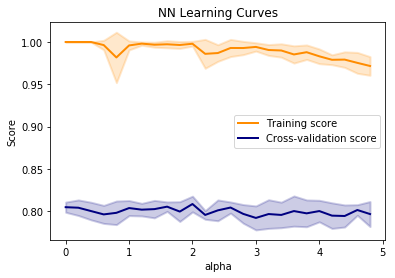

In [74]:
# Standardize the full data kek
kf = KFold(n_splits=5, shuffle = True)
scaler = preprocessing.StandardScaler()
X_standardized = scaler.fit_transform(X)

'''
MLPClassifier(activation='relu', alpha=1e-05, batch_size='auto',
              beta_1=0.9, beta_2=0.999, early_stopping=False,
              epsilon=1e-08, hidden_layer_sizes=(15,),
              learning_rate='constant', learning_rate_init=0.001,
              max_iter=200, momentum=0.9, n_iter_no_change=10,
              nesterovs_momentum=True, power_t=0.5,  random_state=1,
              shuffle=True, solver='lbfgs', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=False)

'''
estimator = MLPClassifier(solver='adam', alpha=1e-5,
                       hidden_layer_sizes=(150,150), random_state=1,
                        activation='relu', learning_rate='constant', beta_1=0.9, 
                          beta_2=0.999, learning_rate_init=0.001, verbose=True,
                          power_t=0.5, tol=0.001, early_stopping=False, max_iter=200
                      )
# train_sizes, train_scores, valid_scores = learning_curve(estimator, X_standardized, y, cv=kf)
plot_validation_curve(estimator, "NN Learning Curves", X_standardized, y, cv=kf,
                        param_name='alpha', param_range=np.arange(1e-5, 5, 0.2), scoring="accuracy")

# Observations: 'sgd' too slow and not better results